<a href="https://colab.research.google.com/github/singhnayaab/hww/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **QUESTION 1**

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.optimize as opt


data = loadmat('/content/drive/MyDrive/Therm3950_Data.mat',
               squeeze_me=True) #loading the file
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Feb  3 22:50:40 2016', '__version__': '1.0', '__globals__': [], 'Resist_Ohm': array([2.772e+05, 2.115e+05, 1.572e+05, 1.166e+05, 8.743e+04, 6.692e+04,
       5.182e+04, 4.045e+04, 3.177e+04, 2.494e+04, 1.968e+04, 1.562e+04,
       1.247e+04, 1.000e+04, 8.064e+03, 6.538e+03, 5.327e+03, 4.363e+03,
       3.592e+03, 2.972e+03, 2.472e+03, 2.066e+03, 1.735e+03, 1.465e+03,
       1.243e+03, 1.059e+03, 9.083e+02, 7.816e+02, 6.744e+02, 5.083e+02,
       3.835e+02, 2.924e+02, 2.258e+02, 1.769e+02, 1.410e+02, 1.139e+02,
       9.280e+01, 7.590e+01, 6.190e+01]), 'Temp_degK': array([233.15, 238.15, 243.15, 248.15, 253.15, 258.15, 263.15, 268.15,
       273.15, 278.15, 283.15, 288.15, 293.15, 298.15, 303.15, 308.15,
       313.15, 318.15, 323.15, 328.15, 333.15, 338.15, 343.15, 348.15,
       353.15, 358.15, 363.15, 368.15, 373.15, 383.15, 393.15, 403.15,
       413.15, 423.15, 433.15, 443.15, 453.15, 463.15, 473.15])}


3.400944830633514e-07 -4.5662581877198e-06 0.0002578507417281584 0.001101958377868954


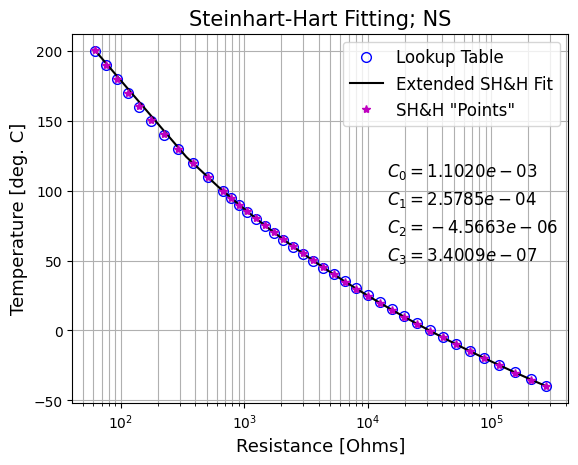

In [65]:
import numpy as np

import matplotlib.pyplot as plt


temps = data['Temp_degK'] # temperature array in kelvin
tempc  = temps - 273.15  # temperature array in degree celsius
res = data['Resist_Ohm'] # resistance array

def steinhart_hart(res, c0, c1, c2, c3):

  '''
  Input:
  res = resistivity array
  c0,c1,c2,c3 = coefficients for SH&H formula

  Output:
  tc = temperature in celsius calculated using SH&H formula
  '''
  x = np.log(res)

  invtk = c0 +c1*x + c2*x**2 + c3*x**3 #inverted temperature

  tc = (1/invtk) - 273.15 # final temperature in celsius
  return tc


c3,c2,c1,c0 = np.polyfit(np.log(res), 1/temps, 3) # using polyfit to find coefficients

#lesson: don't use *args in this case
print(c3,c2,c1,c0)

smoothres = np.linspace(min(res), max(res), 1000) # smooth resistance for best fit


fit_temps = steinhart_hart(smoothres, c0,c1,c2,c3)# finding y values for best fit

#print(fit_temps)


plt.plot(res, tempc, 'bo',markerfacecolor='none', label='Lookup Table', markersize = 7)# raw data

plt.plot(smoothres, fit_temps, 'k-', label='Extended SH&H Fit') # best fit

plt.plot(res, steinhart_hart(res, c0,c1,c2,c3 ), 'm*', label = 'SH&H "Points"' )
# individual best fit values



plt.xscale('log') # log scale to match
plt.xlabel('Resistance [Ohms]', fontsize = 13)
plt.ylabel('Temperature [deg. C]', fontsize = 13)
plt.title('Steinhart-Hart Fitting; NS', fontsize = 15)

# format for the coefficients inspired by ChatGPT
fs = 12
plt.text(100*12**2,110,f"$C_0 = {c0:0.4e}$", fontsize = fs)
plt.text(100*12**2,90,f"$C_1 = {c1:0.4e}$", fontsize = fs)
plt.text(100*12**2,70,f"$C_2 = {c2:0.4e}$", fontsize = fs)
plt.text(100*12**2,50,f"$C_3 = {c3:0.4e}$", fontsize = fs)


plt.legend(fontsize = 12)
plt.grid(which = 'both')
plt.show()

## **QUESTION 2: TEMPDAQ1.py**

In [ ]:
import time
import machine as nano
import math
#Constants
v_in = 3.3
maxlev = 65535.0

GPIO_num = 26 # pin definition
A0 = nano.Pin(GPIO_num)
adc_a0 = nano.ADC(A0)
c3,c2,c1,c0 = [3.400944830633514e-07, -4.5662581877198e-06, 0.0002578507417281584, 0.001101958377868954]
R_fix = 10000.0


def V2R(R_fix, v_read):
  """
  Input:
  R_fix = resistivity of the resistor in circuit
  v_read = voltage signal read

  Output:
  r: resistance of thermistor
  """
  r = R_fix*(v_read/(v_in-v_read)) #formula calculated in class
  return r

def R2T(res, c0,c1,c2,c3):
  '''
  Input:
  res = resistivity array
  c0,c1,c2,c3 = coefficients for SH&H formula

  Output:
  tc = temperature in celsius calculated using SH&H formula
  '''
  x = math.log(res)

  invtk = c0 +c1*x + c2*x**2 + c3*x**3 #inverted temperature

  tc = (1/invtk) - 273.15 # final temperature in celsius
  return tc
#start time:
start = time.ticks_us()
#read:
print("\n")
print("Time[s]   ADC   V   R     Temp") # title of data

while True:

 now = time.ticks_diff(time.ticks_us(),start)
 pinlevel = adc_a0.read_u16() #reads ADC level on pin A0
 v_read = v_in*(pinlevel/maxlev) #V formula from lecture notes

 rth = V2R(R_fix, v_read)
 temp = R2T(rth, c0,c1,c2,c3) #temperature read  by thermistor

 print("{:<9.4f} {:<4} {:<4.2f} {:<6.2f} {:<2.2f}".format(now/10e5, pinlevel, v_read, rth, temp))
 time.sleep(0.25)
print("\n")

## **QUESTION 3**

[[3.000000e-04 3.959300e+04 1.990000e+00 1.526213e+04 2.535000e+01]
 [2.519000e-01 3.968900e+04 2.000000e+00 1.535595e+04 2.522000e+01]
 [5.034000e-01 3.962500e+04 2.000000e+00 1.529333e+04 2.531000e+01]
 ...
 [1.151204e+02 5.070000e+04 2.550000e+00 3.417593e+04 8.370000e+00]
 [1.153717e+02 5.071600e+04 2.550000e+00 3.422362e+04 8.340000e+00]
 [1.156230e+02 5.071600e+04 2.550000e+00 3.422362e+04 8.340000e+00]]


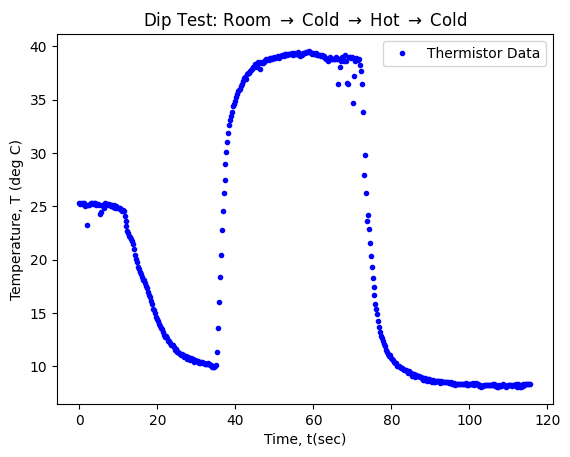

In [ ]:
data = np.loadtxt('/content/drive/MyDrive/DipTest-NayaabSingh.txt', skiprows=1) # loading data

print(data)
time = data[:, 0] # time array
temp = data[:, -1] # temp array

### plotting temp v time ###
plt.plot(time, temp, 'ob', label = 'Thermistor Data', markersize = 3)
plt.ylabel('Temperature, T (deg C)')
plt.xlabel('Time, t(sec)')
plt.title( r'Dip Test: Room $\rightarrow$ Cold $\rightarrow$ Hot $\rightarrow$ Cold')
plt.legend()

## **QUESTION 4**

Text(0.5, 1.0, 'Arduino Voltage divider with $R_{fix} = 10^4 ohm$')

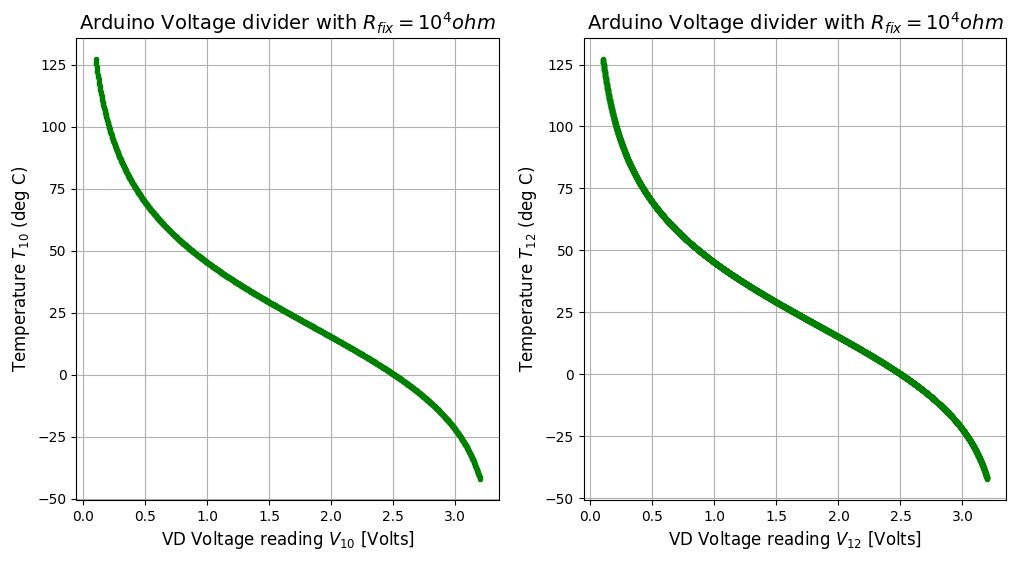

In [ ]:
import matplotlib.gridspec as gspec

def V2T(V_meas,R_fix):
 '''
 Input:
 V_meas: voltage measured by pin
 R_fix: fixed R 10000

 Output:
 t: temperature values using steinhart
    hart equation

 '''

 v_in = 3.3 # input voltage
 r = R_fix*(V_meas/(v_in-V_meas))
 x = np.log(r)
 t = 1/(c0 + c1*x + c2*x**2 + c3*x**3)
 t = t - 273.15 #converting to C
 return t

#v10 array
stepsize = 3e-03
v10 = np.arange(0.1,3.2,stepsize)

#v12 array
step = 0.8e-03
v12 = np.arange(0.1,3.2,step)

#defining figure
fig1 = plt.figure(figsize = (12,6))
spec = gspec.GridSpec(nrows = 1, ncols = 2,figure = fig1)
ax1 = fig1.add_subplot(spec[0,0])
ax2 = fig1.add_subplot(spec[0,1])

### V10 ###
t10 = V2T(v10,10000)
ax1.plot(v10,t10,'.g')
ax1.grid()
ax1.set_xlabel("VD Voltage reading $V_{10}$ [Volts]", fontsize = 12)
ax1.set_ylabel("Temperature $T_{10}$ (deg C)", fontsize = 12)
ax1.set_title("Arduino Voltage divider with $R_{fix} = 10^4 ohm$", fontsize = 14)

### V12 ###
t12 = V2T(v12,10000)
ax2.plot(v12,t12,'.g')
ax2.grid()
ax2.set_xlabel("VD Voltage reading $V_{12}$ [Volts]", fontsize = 12)
ax2.set_ylabel("Temperature $T_{12}$ (deg C)", fontsize = 12)
ax2.set_title("Arduino Voltage divider with $R_{fix} = 10^4 ohm$", fontsize = 14)

Text(0.5, 0, 'T[i]')

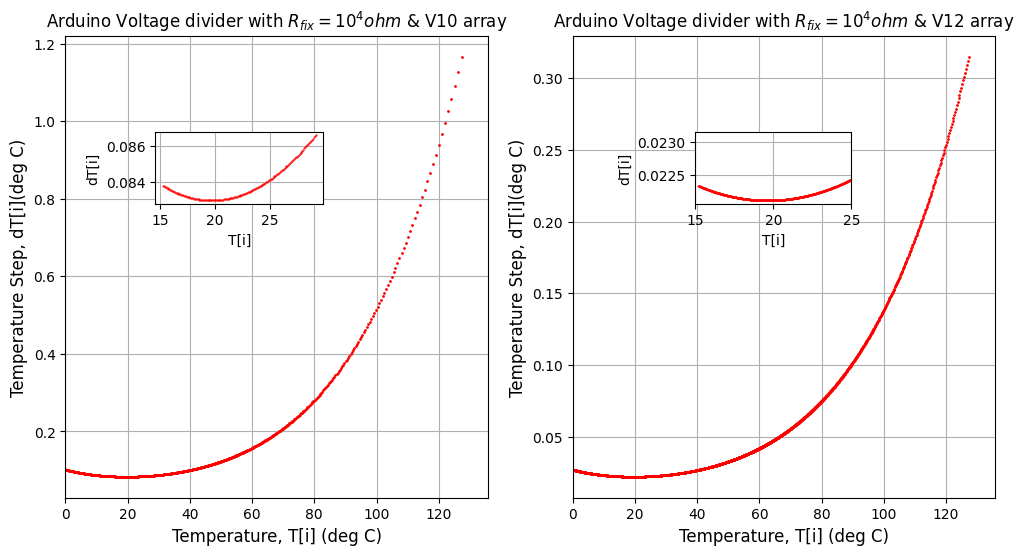

In [ ]:
#defining figure
fig1 = plt.figure(figsize = (12,6))
spec = gspec.GridSpec(nrows = 1, ncols = 2,figure = fig1)
ax1 = fig1.add_subplot(spec[0,0])
ax2 = fig1.add_subplot(spec[0,1])

v_in = v10+stepsize #
t10 = V2T(v10,10000) #calculating temps - T[i]
dt = np.abs(V2T(v_in,10000) - t10)
#finding delta; Calling function to find T[i+1]
#subtracting T[i+1] - T[i] to find delta T

### v10 array delta plotting ###

ax1.plot(t10,dt,'.r', markersize = 2)
ax1.grid()
ax1.set_ylabel("Temperature Step, dT[i](deg C)", fontsize =12)
ax1.set_xlabel("Temperature, T[i] (deg C)", fontsize = 12)
ax1.set_title("Arduino Voltage divider with $R_{fix} = 10^4 ohm $ & V10 array",
              fontsize = 12)
ax1.set_xlim(0)

## plotting zoomed in for v10 ##

left,bottom,width,height = [.20,.60,.14,.12]
ax3 = fig1.add_axes([left,bottom,width,height])
ax3.grid()
v_i = np.arange(1.5,2.0,stepsize)
# this range works for the small plot just did trial and error
#same used for the other small one below

t_i = V2T(v_i,10000)
dt_i = np.abs(V2T(v_i+stepsize,10000) - t_i)
ax3.plot(t_i,dt_i,'.r',markersize = 1)
ax3.set_ylabel('dT[i]')
ax3.set_xlabel('T[i]')
#print(np.argmin(dt))
#print(t10[580])


v_in2 = v12+step
t12 = V2T(v12,10000) #calculating T[i] for v12
dt12 = np.abs(V2T(v_in2,10000) - t12)
#finding delta; making it absolute value to match figure
#finding delta; Calling function to find T[i+1]
#subtracting T[i+1] - T[i] to find delta T

### v12 array delta plotting ###

ax2.plot(t12,dt12,'.r', markersize = 2)
ax2.grid()
ax2.set_ylabel("Temperature Step, dT[i](deg C)", fontsize =12)
ax2.set_xlabel("Temperature, T[i] (deg C)", fontsize = 12)
ax2.set_title("Arduino Voltage divider with $R_{fix} = 10^4 ohm $ & V12 array", fontsize = 12)
ax2.set_xlim(0)

## plotting zoomed in for v12 ##

left,bottom,width,height = [.65,.60,.13,.12]
ax4 = fig1.add_axes([left,bottom,width,height])
ax4.grid()
v_i2 = np.arange(1.5,2.0,step)
t_i2 = V2T(v_i2,10000)
dt_i2 = np.abs(V2T(v_i2+step,10000) - t_i2)
ax4.plot(t_i2,dt_i2,'.r',markersize = 1)
ax4.set_xlim(15,25)
ax4.set_ylabel('dT[i]')
ax4.set_xlabel('T[i]')

In [ ]:
print("Smallest temperature difference with V10 Array:",min(dt_i), 'deg. C')
print("Value at which V10 array produces smallest difference:", t10[np.argmin(dt)], 'deg C')
print('\n')
print("Smallest temperature difference with V12 Array:",min(dt_i2), 'deg. C')
print("Value at which V12 array produces smallest difference:", t12[np.argmin(dt12)], 'deg C')

Smallest temperature difference with V10 Array: 0.08294038389482239 deg. C
Value at which V10 array produces smallest difference: 19.616569933323206 deg C


Smallest temperature difference with V12 Array: 0.022117412276088544 deg. C
Value at which V12 array produces smallest difference: 19.616569933323603 deg C


The resolution is better

for a 12-bit measurement

## **QUESTION 5**



## Playing around with different votlages. My logic is that the curve should not fluctuate too much between temperatures and should remain in a small range for a given resistor to optimize reading. Also using v12 array.

Text(0.5, 1.0, 'Arduino Voltage divider with $R_{fix} = 0.3 $ ohms')

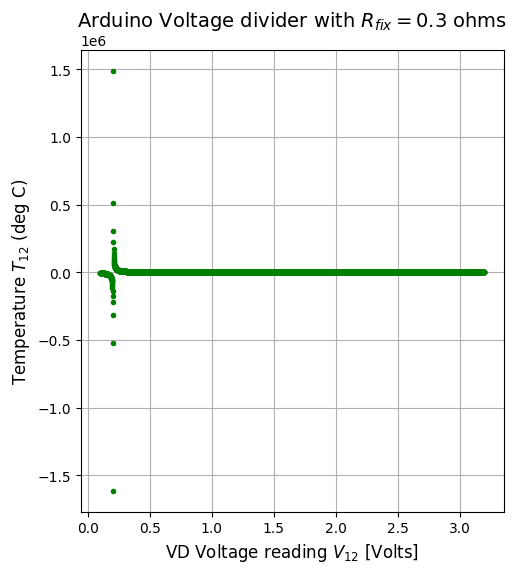

In [61]:
import matplotlib.gridspec as gspec

def V2T(V_meas,R_fix):
 '''
 Input:
 V_meas: voltage measured by pin
 R_fix: fixed R 10000

 Output:
 t: temperature values using steinhart
    hart equation

 '''

 v_in = 3.3 # input voltage
 r = R_fix*(V_meas/(v_in-V_meas))
 x = np.log(r)
 t = 1/(c0 + c1*x + c2*x**2 + c3*x**3)
 t = t - 273.15 #converting to C
 return t

#v10 array
stepsize = 3e-03
v10 = np.arange(0.1,3.2,stepsize)

#v12 array
step = 0.8e-03
v12 = np.arange(0.1,3.2,step)

#defining figure
fig1 = plt.figure(figsize = (12,6))
spec = gspec.GridSpec(nrows = 1, ncols = 2,figure = fig1)
ax1 = fig1.add_subplot(spec[0,0])

### 0.3 ohms ###
t12 = V2T(v12,0.3)
ax1.plot(v12,t12,'.g')
ax1.grid()
ax1.set_xlabel("VD Voltage reading $V_{12}$ [Volts]", fontsize = 12)
ax1.set_ylabel("Temperature $T_{12}$ (deg C)", fontsize = 12)
ax1.set_title("Arduino Voltage divider with $R_{fix} = 0.3 $ ohms", fontsize = 14)



## For an experiment at 0 degrees the smallest resistance is the best as that causes less fluctuations in temperatures. Basically we need a conductor instead of a resistor. If we really want a resistor a sensible value to predict would be $R_{fix}$<<0. So something in the range of 1 - 100 ohms would be good to be realistic: borderline conductors. Best option would be a superconductor.

Text(0.5, 1.0, 'Arduino Voltage divider with $R_{fix} = 175 $ohms')

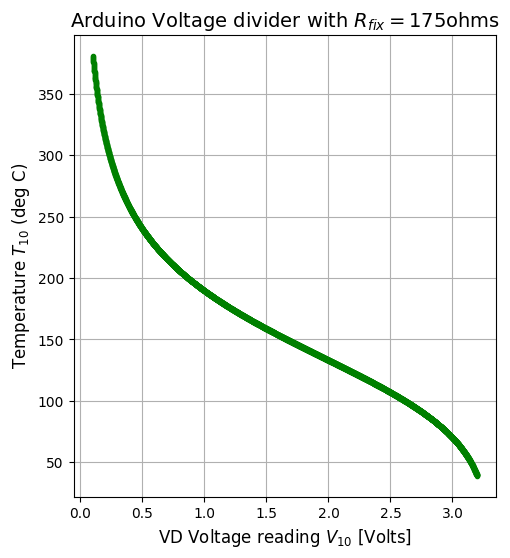

In [66]:
#defining figure
fig1 = plt.figure(figsize = (12,6))
spec = gspec.GridSpec(nrows = 1, ncols = 2,figure = fig1)
ax1 = fig1.add_subplot(spec[0,0])

### 175 ohms ###
t12 = V2T(v12,175)
ax1.plot(v12,t12,'.g')
ax1.grid()
ax1.set_xlabel("VD Voltage reading $V_{10}$ [Volts]", fontsize = 12)
ax1.set_ylabel("Temperature $T_{10}$ (deg C)", fontsize = 12)
ax1.set_title("Arduino Voltage divider with $R_{fix} = 175 $ohms", fontsize = 14)


## A range of 175-200 ohms is optimal as the temperature is around 100 degrees for most of the graph